predictive model using ridge regression


Cross-validation R² scores: [ 0.90858979  0.89297995 -0.01717854  0.9259951   0.89673745]
Mean CV R²: 0.72

Model Evaluation Metrics:
  RMSE: 104.69
   MAE: 76.57
  MAPE: 28.18%


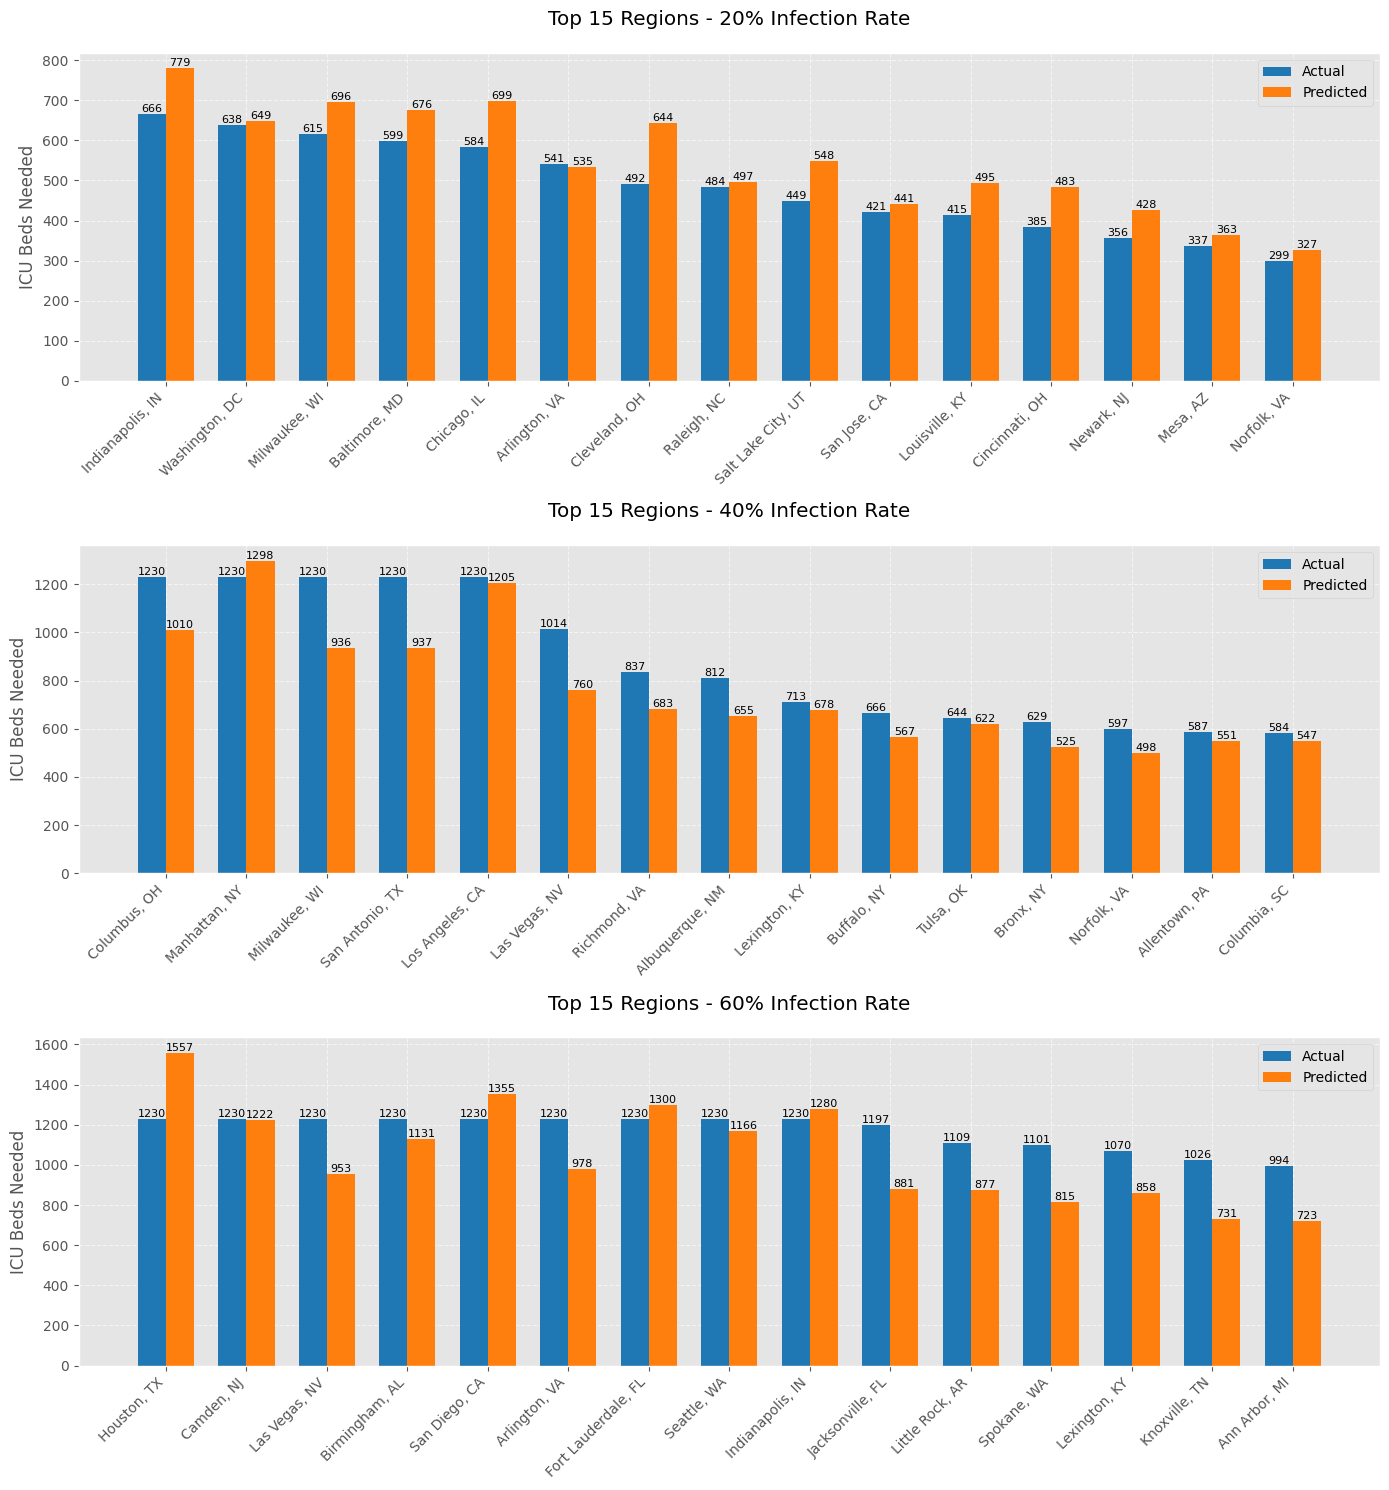

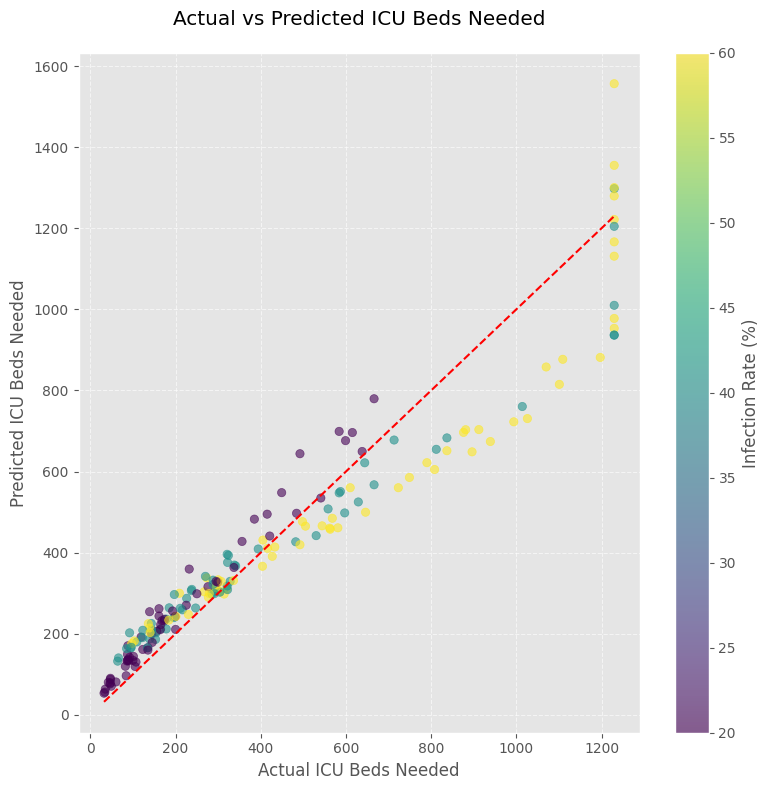

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Set matplotlib style
plt.style.use('ggplot')

# 1) Load and merge all three datasets with infection rate labels
def load_and_merge_data():
    data_files = {
        20: '/content/HRR Scorecard_ 20 _ 40 _ 60 - 20 Population.csv',
        40: '/content/HRR Scorecard_ 20 _ 40 _ 60 - 40 Population.csv',
        60: '/content/HRR Scorecard_ 20 _ 40 _ 60 - 60 Population.csv'
    }

    dfs = []
    for infection_rate, filepath in data_files.items():
        df = pd.read_csv(filepath)
        df = df[df['HRR'] != '*Based on a 50% reduction in occupancy'].copy()
        df['Infection_Rate'] = infection_rate
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

df = load_and_merge_data()

# 2) Data cleaning function
def clean_data(df):
    numeric_cols = [
        'Adult Population', 'Population 65+',
        'Available Hospital Beds', 'Available ICU Beds',
        'Total ICU Beds', 'Projected Infected Individuals',
        'Projected Hospitalized Individuals', 'ICU Beds Needed, Twelve Months'
    ]

    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(
                df[col].astype(str).str.replace(',', ''),
                errors='coerce'
            )

    # Clip outliers using IQR method
    q1 = df['ICU Beds Needed, Twelve Months'].quantile(0.25)
    q3 = df['ICU Beds Needed, Twelve Months'].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr

    df['ICU Beds Needed, Twelve Months'] = df['ICU Beds Needed, Twelve Months'].clip(upper=upper_bound)

    return df.dropna(subset=['ICU Beds Needed, Twelve Months'])

df = clean_data(df)

# 3) Define features & target
features = [
    'Adult Population', 'Population 65+',
    'Available Hospital Beds', 'Available ICU Beds',
    'Total ICU Beds', 'Projected Infected Individuals',
    'Projected Hospitalized Individuals', 'Infection_Rate'
]
target = 'ICU Beds Needed, Twelve Months'

# 4) Prepare data
X = df[features]
y = df[target]

# 5) Train-test split (without feature selection to keep Infection_Rate)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=X['Infection_Rate']
)

# 6) Build and train model
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
)

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {np.mean(cv_scores):.2f}")

model.fit(X_train, y_train)

# 7) Evaluation
y_pred = model.predict(X_test)

def print_metrics(y_true, y_pred):
    metrics = {
        'RMSE': mean_squared_error(y_true, y_pred)**0.5,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

    print("\nModel Evaluation Metrics:")
    for name, value in metrics.items():
        print(f"{name:>6}: {value:.2f}{'%' if name == 'MAPE' else ''}")

print_metrics(y_test, y_pred)

# 8) Visualization by infection rate
def plot_results_by_infection_rate(y_true, y_pred, test_indices, df):
    results = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Infection_Rate': df.loc[test_indices, 'Infection_Rate'],
        'Region': df.loc[test_indices, 'HRR']
    })

    fig, axes = plt.subplots(3, 1, figsize=(14, 15))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, green

    for idx, rate in enumerate([20, 40, 60]):
        ax = axes[idx]
        rate_data = results[results['Infection_Rate'] == rate]
        top_regions = rate_data.nlargest(15, 'Actual')

        x = np.arange(len(top_regions))
        width = 0.35

        actual_bars = ax.bar(x - width/2, top_regions['Actual'], width,
                            label='Actual', color=colors[0])
        pred_bars = ax.bar(x + width/2, top_regions['Predicted'], width,
                          label='Predicted', color=colors[1])

        ax.set_title(f'Top 15 Regions - {rate}% Infection Rate', pad=20)
        ax.set_ylabel('ICU Beds Needed')
        ax.set_xticks(x)
        ax.set_xticklabels(top_regions['Region'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

        # Add value labels
        for bar in actual_bars + pred_bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_results_by_infection_rate(y_test, y_pred, y_test.index, df)


# 10) Actual vs Predicted scatter plot
plt.figure(figsize=(8, 8))
# Get infection rates from the original X_test before any transformations
infection_rates = X_test['Infection_Rate'].values
plt.scatter(y_test, y_pred, c=infection_rates, cmap='viridis', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
cbar = plt.colorbar()
cbar.set_label('Infection Rate (%)')
plt.title('Actual vs Predicted ICU Beds Needed', pad=20)
plt.xlabel('Actual ICU Beds Needed')
plt.ylabel('Predicted ICU Beds Needed')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()